In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install pygam
from pygam import LinearGAM, s


In [2]:
from dataretrieval import nwis
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

#!pip uninstall scikit-learn -y
#!pip install scikit-learn 
import sklearn
# Print the version of scikit-learn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from datetime import datetime
current_time = datetime.now()
print(current_time.strftime("%Y-%m-%d %H:%M:%S"))

startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = [
    "13092747"  
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

1.6.1
2025-03-26 09:24:01


In [3]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va' 
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( dailyStreamtemp_df.head() )

                     datetime   site_no  00010_Maximum 00010_Maximum_cd  \
244 1996-06-01 00:00:00+00:00  13092747            NaN              NaN   
245 1996-06-02 00:00:00+00:00  13092747            NaN              NaN   
246 1996-06-03 00:00:00+00:00  13092747            NaN              NaN   
247 1996-06-04 00:00:00+00:00  13092747            NaN              NaN   
248 1996-06-05 00:00:00+00:00  13092747            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN       198.0   
245            NaN              NaN         NaN           NaN       190.0   
246            NaN              NaN         NaN           NaN       192.0   
247            NaN              NaN         NaN           NaN       181.0   
248            NaN              NaN         NaN           NaN       170.0   

    00060_Mean_cd        Date  Month  Year  
244             A  1996-06-01      6  199

In [4]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date']) 
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days   
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date
print( prism_df)

             date      tmean   site_no  Days_Since_October_1st     rad_d  \
0      1995-01-01 -18.306002  06038800                      92  1.583707   
1      1995-01-02 -17.829000  06038800                      93  1.600921   
2      1995-01-03 -18.317001  06038800                      94  1.618135   
3      1995-01-04 -15.904000  06038800                      95  1.635350   
4      1995-01-05 -11.903001  06038800                      96  1.652564   
...           ...        ...       ...                     ...       ...   
282875 2024-10-10  14.149199  13342500                       9  0.154928   
282876 2024-10-11  13.611249  13342500                      10  0.172142   
282877 2024-10-12  16.385151  13342500                      11  0.189356   
282878 2024-10-13  14.676150  13342500                      12  0.206570   
282879 2024-10-14  16.204950  13342500                      13  0.223785   

              Date  
0       1995-01-01  
1       1995-01-02  
2       1995-01-03  
3  

In [5]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
#print(result)

#print(result.columns)

# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print(na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )

tmean                        0
site_no                      0
Date                         0
rad_d                        0
Days_Since_October_1st       0
00010_Mean                1291
00060_Mean                   0
Month                        0
Year                         0
dtype: int64
        tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42  23.403002  13092747  1996-07-13  4.906049                     285   
43  23.366001  13092747  1996-07-14  4.923263                     286   
44  24.110001  13092747  1996-07-15  4.940477                     287   
45  21.022001  13092747  1996-07-16  4.957691                     288   
46  21.528002  13092747  1996-07-17  4.974906                     289   

    00010_Mean  00060_Mean  Month  Year  
42        18.6       120.0      7  1996  
43        18.4       130.0      7  1996  
44        18.3       132.0      7  1996  
45        17.9       134.0      7  1996  
46        18.0       155.0      7  1996  
tmean            

In [6]:
def get_water_year(date):
        if date.month >= 10: 
            return date.year +1
        else:   
            return date.year

df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_18398/286143813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


In [7]:
df_cleaned

df_cleaned.to_csv("df_cleaned.csv")

In [8]:
input=  df_cleaned[  idv]

X_train, X_test, y_train, y_test = train_test_split( input,  df_cleaned['00010_Mean'], test_size=0.2, random_state=42)

print(X_train)

      00060_Mean      tmean  Days_Since_October_1st
1739       242.0  16.012001                     326
1874       107.0  19.823002                     277
609         94.5  22.113001                     300
1657        88.5  18.363001                     244
1935       109.0  20.578001                     246
...          ...        ...                     ...
2385       150.0  19.844000                     328
2420        63.1  20.542900                     271
2584       103.0  21.545650                     251
2146        72.4  21.228399                     273
2416        68.3  19.048399                     267

[1101 rows x 3 columns]


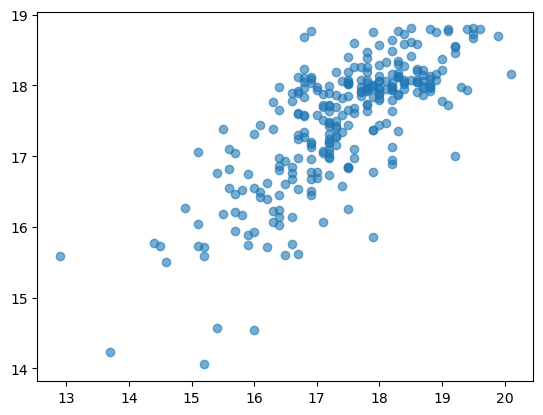

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

X= X_train
y= y_train

# Fit a GAM model with a smoothing spline on X
gam = LinearGAM(s(   1)).fit(X, y)



y_pred = gam.predict( X_test)



plt.scatter( y_test , y_pred, label=" ", alpha=0.6)


plt.show()


In [10]:
r2 = r2_score( y_test , y_pred)
print(r2)

0.5598974440722024


In [11]:
# Number of samples and predictors
n =  X_test.shape[0]  # Number of test samples
print(n)
p =  X_test.shape[1]  # Number of predictors
print(p)

# Compute Adjusted R-squared
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
print(adj_r2)

276
3
0.5550433717641752


In [12]:
mse = mean_squared_error( y_test , y_pred )
rmse = np.sqrt(mse)
print(rmse)

0.7458741574030577


In [13]:
# Compute null deviance and residual deviance
print("Null Deviance:", gam.statistics_['AIC'] - 2 * gam.statistics_['edof'])
print("Residual Deviance:", gam.statistics_['deviance'])

Null Deviance: 2705.7417673921186
Residual Deviance: 1087.6724535482333


AICw represents the relative likelihood of a
model being the ‘true’ model compared to the model with the lowest AIC
score, and values can range from 0.0–1.0 (Burnham and Anderson,
2002).

In [14]:
gam.statistics_

{'n_samples': 1101,
 'm_features': 3,
 'edof_per_coef': array([8.18186120e-01, 3.63030173e-01, 3.72811162e-01, 4.55140092e-01,
        6.17249311e-01, 5.86617032e-01, 6.42465307e-01, 7.19106833e-01,
        7.25464002e-01, 7.61580191e-01, 7.95655409e-01, 8.22899860e-01,
        8.50679680e-01, 8.57802693e-01, 8.77144209e-01, 8.39377867e-01,
        8.12102205e-01, 7.09054128e-01, 6.69869473e-01, 3.13107047e-02,
        2.06603347e-21]),
 'edof': 13.327546451766752,
 'scale': 0.5876329366509511,
 'cov': array([[ 7.02461739e-01,  3.25204534e-01, -1.19433940e-02,
         -1.25289302e-01, -7.73258643e-02, -4.26017463e-02,
         -4.71517103e-02, -4.99092499e-02, -4.84601653e-02,
         -4.83689351e-02, -4.83511283e-02, -4.82365317e-02,
         -4.81919980e-02, -4.82375246e-02, -4.79939094e-02,
         -4.86813307e-02, -4.74346927e-02, -4.82818420e-02,
         -6.28177639e-02, -8.03752108e-02,  4.80139877e-02],
        [ 3.25204534e-01,  1.74004683e-01,  3.35956944e-02,
         -4.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Create a Linear Regression object
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

#print("\nModel trained successfully!")

LinearRegression()

In [17]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

print("\nPredictions on the test set (first 10):\n", y_pred[:10])
print("\nActual values on the test set (first 10):\n", y_test[:10].values)


Predictions on the test set (first 10):
 [18.01436013 18.58086203 18.52112085 17.53778329 17.56169636 16.65581358
 16.40270818 18.96021159 16.50980117 16.87398274]

Actual values on the test set (first 10):
 [16.7 18.2 19.  17.8 18.  15.7 15.8 19.1 15.7 17.6]


In [18]:

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 0.51
R-squared (R²): 0.59


In [19]:
import statsmodels.api as sm

# Add a constant to the independent variables for the intercept term
X_train_sm = sm.add_constant(X_train)
print(X_train_sm)
X_test_sm = sm.add_constant(X_test)

# Fit the OLS (Ordinary Least Squares) model
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary of the model
print(model_sm.summary())

# Make predictions using the statsmodels model
y_pred_sm = model_sm.predict(X_test_sm)

# Evaluate the statsmodels predictions (optional, as sklearn metrics can still be used)
mse_sm = mean_squared_error(y_test, y_pred)
r2_sm = r2_score(y_test, y_pred_sm)
print(f"\nStatsmodels MSE: {mse_sm:.2f}")
print(f"Statsmodels R-squared: {r2_sm:.2f}")

      const  00060_Mean      tmean  Days_Since_October_1st
1739    1.0       242.0  16.012001                     326
1874    1.0       107.0  19.823002                     277
609     1.0        94.5  22.113001                     300
1657    1.0        88.5  18.363001                     244
1935    1.0       109.0  20.578001                     246
...     ...         ...        ...                     ...
2385    1.0       150.0  19.844000                     328
2420    1.0        63.1  20.542900                     271
2584    1.0       103.0  21.545650                     251
2146    1.0        72.4  21.228399                     273
2416    1.0        68.3  19.048399                     267

[1101 rows x 4 columns]
                            OLS Regression Results                            
Dep. Variable:             00010_Mean   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least 

In [20]:
np.sqrt(0.51)

0.714142842854285

AIC (Akaike Information Criterion) is a statistical measure used to assess the model's quality by balancing goodness-of-fit and model complexity.

AIC is a relative measure, meaning its absolute value is not as important as its value compared to the AIC of other models fitted to the same data. 

The log-likelihood measures the probability of the observed data given the model parameters

In [22]:
# Calculate mean of y for total deviance
y_mean = np.mean( y_test)


total_deviance = np.sum(( y_test - y_mean) ** 2)          # SST
explained_deviance = np.sum((y_pred - y_mean) ** 2)  # SSR
residual_deviance = np.sum(( y_test - y_pred) ** 2)        # SSE

In [25]:


print( total_deviance )
print( explained_deviance )
print( residual_deviance)

348.8882246376812
233.3422488382223
141.45687167232376


Deviance = -2 * [Log-Likelihood(Fitted Model) - Log-Likelihood(Saturated Model)]